In [1]:
def nextBaseStep(fromIdx, toIdx, baseAggr=100):
    # get next loan idx that is closest in terms of mod baseAggr
    nextIdx = (fromIdx // baseAggr + 1) * baseAggr
    # make sure next doesn't "overstep" toIdx
    return min([nextIdx, toIdx])

def buildBaseAggrRanges(loanIdxsWhereSharesChanged, baseAggr=100):
    baseAggrRanges = loanIdxsWhereSharesChanged.copy()
    i = 0
    n = len(baseAggrRanges) - 1
    while (i < n):
        # get next loan idx in terms of mod baseAggr
        nextStep = nextBaseStep(baseAggrRanges[i], baseAggrRanges[i+1], baseAggr)
        # make sure we don't insert duplicates
        if (nextStep != baseAggrRanges[i+1]):
            baseAggrRanges.insert(i+1, nextStep)
            n = len(baseAggrRanges) - 1
        i += 1
    return baseAggrRanges

def prune(baseRanges, pruneBy=1000):
    pruned = [baseRanges[0]]
    i = 0
    n = len(baseRanges)
    while (i < n):
        # make sure we don't insert duplicates
        if pruned[-1] != baseRanges[i]:
            pruned.append(baseRanges[i])
        # check if loan idx is potentially starting point for range that can be pruned
        if baseRanges[i] % pruneBy == 0 and i + 10 < n:
            canBePruned = True
            for j in range(10):
                # check that next next 10 loan idxs can all be pruned
                if baseRanges[i+j+1] % (pruneBy/10) != 0:
                    canBePruned = False
                    break
            # if range can be pruned, add the 10th item and move forward by 10
            if canBePruned:
                pruned.append(baseRanges[i+j+1])
                i += 10
            else:
                i += 1
        else:
            i += 1
    return pruned

def packIntoClaimingTxs(pruned):
    packed = []
    i = 0
    n = len(pruned)-1
    while (i < n):
        consecutive100 = pruned[i] % 100 == 0 and pruned[i+1] % 100 == 0
        consecutive1000 = pruned[i] % 1000 == 0 and pruned[i+1] % 1000 == 0
        consecutive10000 = pruned[i] % 10000 == 0 and pruned[i+1] % 10000 == 0
        if (consecutive100 or consecutive1000 or consecutive10000):
            j = 0
            tmp = [pruned[i]]
            while (i+j+1 < n):
                diff = 100 if consecutive100 else (1000 if consecutive1000 else 10000)
                if (pruned[i+j+1] - pruned[i]) % diff == 0:
                    tmp.append(pruned[i+j+1])
                    j += 1
                else:
                    break
            i += j
            packed.append(tmp)
        else:
            packed.append([pruned[i], pruned[i+1]])
            i += 1
    return packed
            
            
# example array of where LP changed position
loanIdxsWhereSharesChanged = [1, 98, 313, 500, 600, 1013, 9982]

# first construct array with "intermediate" steps according to baseAggr
baseAggrRanges = buildBaseAggrRanges(loanIdxsWhereSharesChanged, 100)
print("baseAggrRanges:\n", baseAggrRanges, "\n")

# next, try pruning by 1'000 intervals
prunedBy1000 = prune(baseAggrRanges, 1000)
print("prunedBy1000:\n", prunedBy1000, "\n")

# finally, try pruning by 10'000 intervals
prunedBy10000 = prune(prunedBy1000, 10000)
print("prunedBy10000:\n", prunedBy10000, "\n")

# get packed claiming intervals
packed = packIntoClaimingTxs(prunedBy10000)
print("packed:\n", packed, "\n")

print("loanIdxsWhereSharesChanged: ", loanIdxsWhereSharesChanged)
print("changed position {} times".format(len(loanIdxsWhereSharesChanged)))
print("need to claim {} times".format(len(packed), "\n"))

baseAggrRanges:
 [1, 98, 100, 200, 300, 313, 400, 500, 600, 700, 800, 900, 1000, 1013, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 9982] 

prunedBy1000:
 [1, 98, 100, 200, 300, 313, 400, 500, 600, 700, 800, 900, 1000, 1013, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 9982] 

prunedBy10000:
 [1, 98, 100, 200, 300, 313, 400, 500, 600, 700, 800, 900, 1000, 1013, 1100, 1200, 1300, 1400, 1500, 1600, 

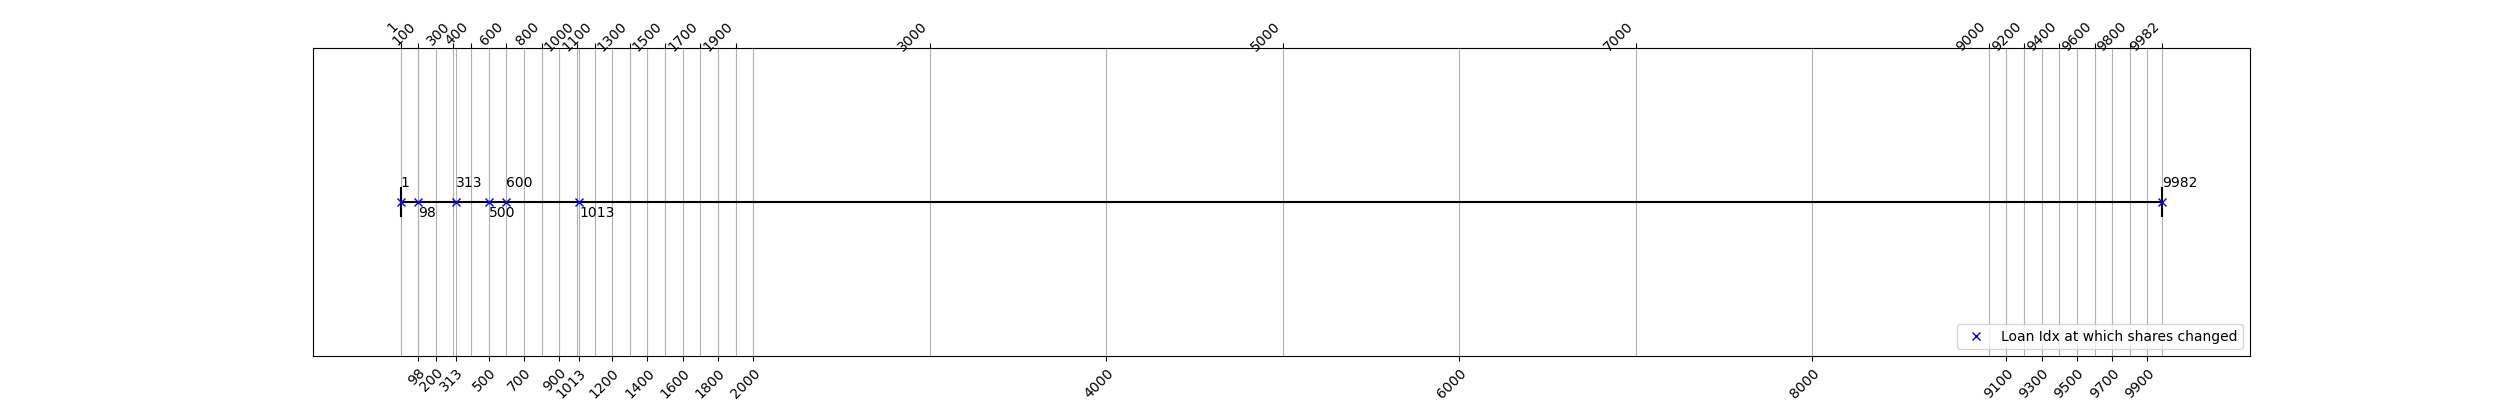

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0,10)
ax.set_ylim(0,10)

xmin = min(loanIdxsWhereSharesChanged)
xmax = max(loanIdxsWhereSharesChanged)

fig, ax = plt.subplots(figsize=(25, 4))
plt.plot([xmin, xmax], [0, 0], c="black")
plt.vlines(xmin, -0.1, 0.1, color="black")
plt.vlines(xmax, -0.1, 0.1, color="black")

for i, loanIdx in enumerate(loanIdxsWhereSharesChanged):
    if i == 0:
        plt.plot(loanIdx, 0, "x", c="blue", label="Loan Idx at which shares changed")
    else:
        plt.plot(loanIdx, 0, "x", c="blue")
    ax.annotate(loanIdx, (loanIdx, 0.1*(-1)**i))
    
plt.yticks([])
plt.ylim(-1, 1)

ax.grid(axis='x', which='major')
ax.set_xticks(prunedBy1000, linestyle='--')

for i, tick in enumerate(ax.xaxis.get_major_ticks()):
    if i % 2 == 0:
        tick.tick1line.set_visible(False)
        tick.label1.set_visible(False)
        tick.set_pad(10)
        tick.tick2line.set_visible(True)
        tick.label2.set_visible(True)
    else:
        tick.tick1line.set_visible(True)
        tick.label1.set_visible(True)
        tick.tick2line.set_visible(False)
        tick.label2.set_visible(False)

# rotate axis
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

vnumLoans = [100, 200, 500]
vnumPosChanges = [2, 5, 10]

plotData = []
for numLoans in vnumLoans:
    tmp = []
    for numPosChanges in vnumPosChanges:
        avg = 0
        for numSims in range(100):
            loanIdxsWhereSharesChanged = np.random.choice(numLoans, numPosChanges, replace=False)
            loanIdxsWhereSharesChanged = np.sort(loanIdxsWhereSharesChanged).tolist()
            claimBuckets = buildBaseAggrRanges(loanIdxsWhereSharesChanged, 100)
            claimBuckets = prune(claimBuckets, 1000)
            claimBuckets = prune(claimBuckets, 10000)
            packed = packIntoClaimingTxs(claimBuckets)
            claimOverhead = len(packed)
            avg += claimOverhead/100
        tmp.append(avg)
    plotData.append(tmp)
            
fig, ax = plt.subplots()
im = ax.imshow(plotData, cmap="Reds")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vnumLoans)):
    for j in range(len(vnumPosChanges)):
        text = ax.text(j, i, str(round(plotData[i][j],1)),
                       ha="center", va="center", color="black", size="x-small")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(0, len(vnumLoans)), labels=vnumLoans)
ax.set_yticks(np.arange(0, len(vnumPosChanges)), labels=vnumPosChanges)
ax.set_xlabel('No. Loans')
ax.set_ylabel('No. Position Changes')

ax.set_title("Avg. No. of Required Claiming TXs")
fig.tight_layout()
plt.show()